In this notebook, I'm going to:
* Reimplement the retraining algorithm from last week, but using standard deviations instead of residuals,
* Compare the final model's performance to a model that starts with the number of training points built up to in the initial retraining algorithm

In [1]:
#importing libraries
import numpy as np
from sklearn import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#allocating datasets and model to GPU for speed's sake
is_available = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


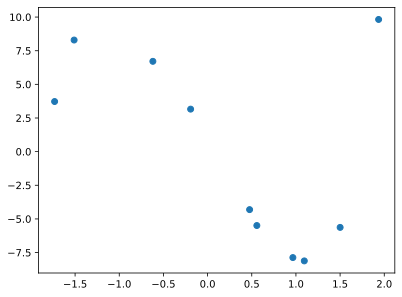

In [3]:
#creating training data
x_train = torch.rand(10)*4-2
y_train = x_train.pow(5) - 10 * x_train.pow(1) + 2*torch.rand(x_train.size())

#plotting training data
plt.scatter(x_train.data.numpy(), y_train.data.numpy())
plt.show()

#allocating training data to GPU
x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)


In [4]:
#defining functions
def clean_target(x):
    return x.pow(5) - 10 * x.pow(1)+1


def target(x):
    return x.pow(5) - 10 * x.pow(1) + 2*torch.rand(x.size())


In [5]:
#intialising model
no_of_neurones = 2000

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1,
                    out_features=no_of_neurones),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=no_of_neurones, out_features=1),
).to(device)


In [6]:
mse_loss = nn.MSELoss().to(device)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)


In [7]:
def train(model: nn.Sequential, x_train: torch.Tensor, y_train: torch.Tensor, epochs: int):
    """
    Trains the given Bayesian Neural Network model using Mean Squared Error (MSE) and Kullback-Leibler (KL) divergence.

    Parameters:
    - model (nn.Sequential): The Bayesian Neural Network model to be trained.
    - x_train (torch.Tensor): The training data input.
    - y_train (torch.Tensor): The corresponding ground truth values for the training data.
    - epochs (int): The number of epochs for which the model should be trained.

    Returns:
    - model (nn.Sequential): The trained model.
    - mse (torch.Tensor): Mean Squared Error for the model on the training data after training.
    - kl (torch.Tensor): Kullback-Leibler divergence for the model after training.
    - cost (torch.Tensor): The combined cost (MSE + weighted KL) for the model after training.

    Note:
    - Assumes that the `mse_loss`, `kl_loss`, `kl_weight`, and `optimizer` are globally defined.
    - The function will print the MSE, KL, and Cost for the model after training for the given number of epochs.
    """

    for _ in range(epochs):
        predictions = model(x_train)
        mse = mse_loss(predictions, y_train)
        kl = kl_loss(model)
        cost = mse + kl_weight * kl

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

    print(f'- With {epochs} epochs, MSE : {mse.item():2.2f}, KL : {kl.item():2.2f}, Cost: {cost.item():2.2f}')

    return model, mse, kl, cost

In [8]:
#training model
epochs = 750
model, mse, kl, cost = train(model, x_train, y_train, epochs)

#creating testing data
x_test = torch.sort(torch.rand(300)*4-2)[0]
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1).to(device) 
y_test = torch.unsqueeze(y_test, dim=1).to(device)

#producing predictions of model of testing data, as well as mean and standard deviation of predictions
model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])

#calculating mse for retraining purposes
test_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_model_results), dim=1).to(device), y_test)

- With 750 epochs, MSE : 1.72, KL : 8.62, Cost: 1.80


20
- With 750 epochs, MSE : 1.11, KL : 8.25, Cost: 1.20
MSE: 1.86
30
- With 750 epochs, MSE : 1.50, KL : 8.81, Cost: 1.59
MSE: 1.11
40
- With 750 epochs, MSE : 0.45, KL : 9.03, Cost: 0.54
MSE: 0.93
Cost sufficiently minimised


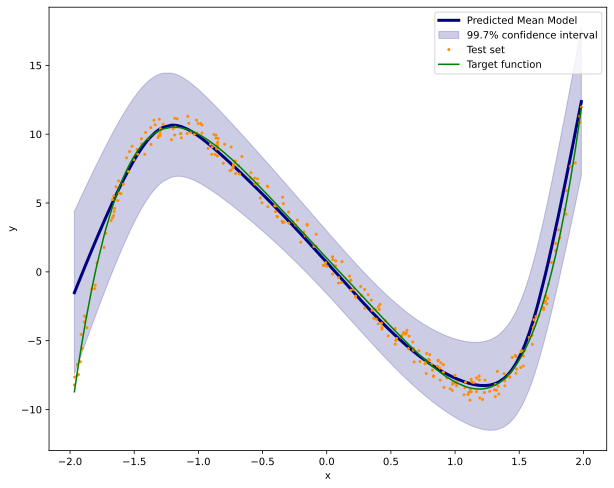

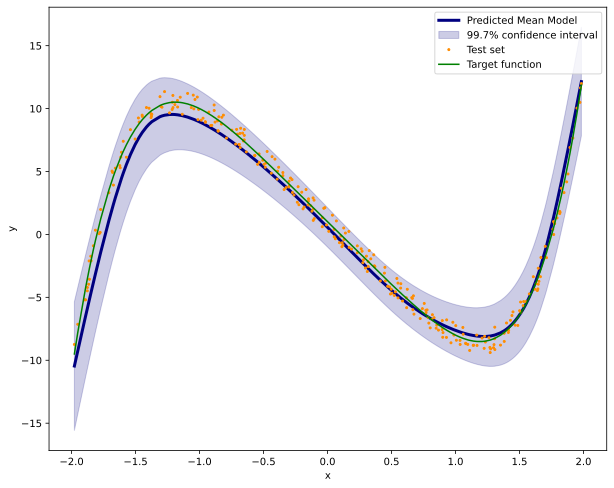

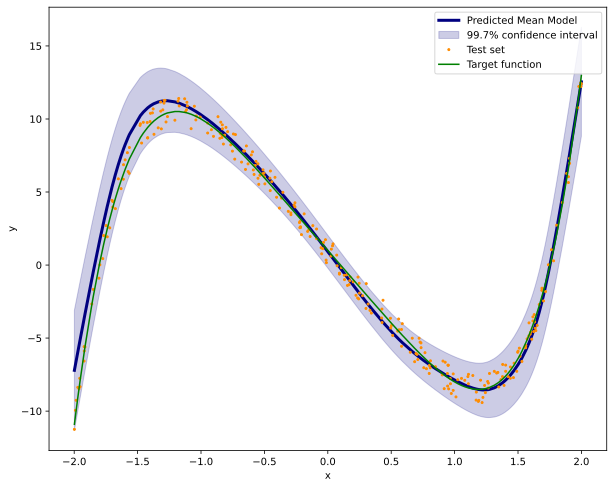

In [9]:
while test_mse > 1.0:
    #reallocating datasets to CPU for NumPy operations
    x_test = x_test.cpu()
    y_test = y_test.cpu()

    #forming df of standard deviations of model results, and the x values they correspond to
    differences = np.abs(mean_model_results - y_test.data.numpy()[:, 0])
    df = pd.DataFrame(
        {
            "x": x_test[:, 0],
            "differences": std_model_results
        }
    ).sort_values(by=['differences'], ascending=False)
    df.head()

    #dataset to add to training set for retraining
    x_to_add = np.array([])

    #select 10 random values from x_to_add to add to x_train
    for i in range(0, len(df)+1, 50):
        x_to_add = np.append(x_to_add, df.iloc[i:i+10, 0])

    #randomly selecting 10 points from x_to_add to add to x_train
    x_to_add = torch.unsqueeze(torch.Tensor(np.random.choice(x_to_add, 10, replace=False)), dim=1).to(device)
    y_to_add = target(x_to_add.cpu()).to(device)

    x_train = torch.sort(torch.cat((x_train, x_to_add)).to(device))[0]
    y_train = torch.cat((y_train, y_to_add))
    print(len(x_train))

    #retraining model
    model, mse, kl, cost = train(model, x_train, y_train, epochs)

    #creating testing data
    x_test = torch.sort(torch.rand(300)*4-2)[0]
    y_test = target(x_test)

    x_test = torch.unsqueeze(x_test, dim=1).to(device)
    y_test = torch.unsqueeze(y_test, dim=1).to(device)

    model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
    mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
    std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])

    test_mse = mse_loss(torch.unsqueeze(torch.Tensor(mean_model_results), dim=1).to(device), y_test)
    print(f'MSE: {test_mse.item():2.2f}')

    #reallocating datasets to CPU for plotting
    x_test = x_test.cpu()
    y_test = y_test.cpu()

    #plotting results
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)

    ax.plot(x_test.data.cpu().numpy(), mean_model_results, color='navy',
            lw=3, label='Predicted Mean Model')
    ax.fill_between(x_test.data.cpu().numpy().T[0], mean_model_results-3.0*std_model_results, mean_model_results +
                    3.0*std_model_results, alpha=0.2, color='navy', label='99.7% confidence interval')
    ax.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
            color='darkorange', markersize=4, label='Test set')
    ax.plot(x_test.data.cpu().numpy(), clean_target(x_test).cpu().data.numpy(),
            color='green', markersize=4, label='Target function')
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    if(test_mse <= 1.0):
        break

print("Cost sufficiently minimised")



Now, I'm going to train a model with a training set of the same length as the one used to generate the graph above, to see if there is a difference between iteratively retraining a model and just training it once with a more realistic training set size.

In [11]:
#the fixed dataset approach - essentially the same as the iterative retraining approach, but without the iteration
train_set_size = len(x_train)
x_train = torch.sort(torch.rand(train_set_size)*4-2)[0]
y_train = target(x_train)

x_train = torch.unsqueeze(x_train, dim=1).to(device)
y_train = torch.unsqueeze(y_train, dim=1).to(device)


In [12]:
no_of_neurones = 2000

model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1,
                    out_features=no_of_neurones),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1,
                    in_features=no_of_neurones, out_features=1),
).to(device)

mse_loss = nn.MSELoss().to(device)
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False).to(device)
kl_weight = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01)

You might ask, "why have you reinitialised your model here?"

The reason is so that the methods used to generate predictions are independent of the model, since what we're testing is the method, not the model's architecture.

Worded slightly differently, if I use the model already used in the iterative training method for the fixed dataset method, I will end up using an already trained model to further train it to predict a set of y values. This is pointless; by this reasoning, method 2 will always be more accurate than method 1. 

In [13]:
model, mse, kl, cost = train(model, x_train, y_train, epochs)

#creating testing data
x_test = torch.sort(torch.rand(300)*4-2)[0]
y_test = target(x_test)

x_test = torch.unsqueeze(x_test, dim=1).to(device) 
y_test = torch.unsqueeze(y_test, dim=1).to(device)


model_results = np.array([model(x_test).cpu().data.numpy() for _ in range(10000)])[:,:,0].T
mean_model_results = np.array([np.mean(model_results[i]) for i in range(model_results.shape[0])])
std_model_results = np.array([np.std(model_results[i]) for i in range(model_results.shape[0])])

- With 750 epochs, MSE : 4.54, KL : 8.84, Cost: 4.63


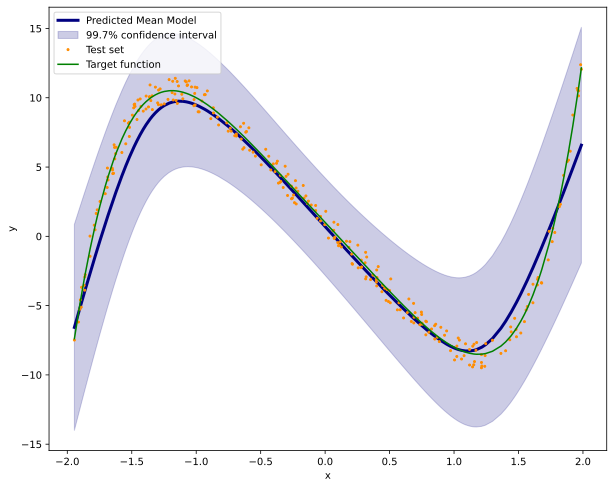

In [14]:
x_test = x_test.cpu()
y_test = y_test.cpu()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.plot(x_test.data.cpu().numpy(), mean_model_results, color='navy',
        lw=3, label='Predicted Mean Model')
ax.fill_between(x_test.data.cpu().numpy().T[0], mean_model_results-3.0*std_model_results, mean_model_results +
                3.0*std_model_results, alpha=0.2, color='navy', label='99.7% confidence interval')
ax.plot(x_test.data.numpy(), y_test.data.numpy(), '.',
        color='darkorange', markersize=4, label='Test set')
ax.plot(x_test.data.cpu().numpy(), clean_target(x_test).cpu().data.numpy(),
        color='green', markersize=4, label='Target function')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.savefig(f"../../plots/iterative_retraining_vs_fixed_dataset/fixed_{len(x_train)}_plots.pdf")

Yeah, model 1 (the iterative retrainer) performs better than model 2 (the fixed dataset trainer), by eye. This is rather obvious, considering how the model is increasingly trained on existing portions of the training set the more iterations that occur. Further, I'm retraining the model in model 1 based on mse; it's entire purpose is to produce an accurate model. Model 2 is just, "here's some data to train on. Do your best."